In [1]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import openpyxl as xl
import os

In [2]:
plt.style.use(['science', 'notebook', 'grid'])
mm, um, nm = (10**(-3), 10**(-6), 10**(-9))

def sci_notation(number: float, n_decimals: int = 2) -> str:
    sci_notation = f"{number:e}"
    decimal_part, exponent = sci_notation.split("e")
    decimal_part = float(decimal_part)
    exponent = int(exponent)

    if decimal_part == 1.0:
        return f"$10^{exponent}$"
    else:
        return f"{decimal_part:.{n_decimals}f}$\cdot 10^{exponent}$"    

# Simulation

In [215]:
def simulate_single_slit_diffraction_theta(theta, D, k):
    beta = (k*D/2) * np.sin(theta)
    return (np.sin(beta) / beta) ** 2

def single_slit_diffraction_x(x, D, k):
    beta = k *  x / 2
    return (np.sin(beta) / beta) ** 2

In [216]:
%matplotlib inline
from ipywidgets import interact, FloatSlider

def simulate_single_slit(D):
    # Wave parameters
    lam = 632.6 * nm
    k = 2*np.pi / lam
    nx = 500

    # I of theta
    theta = np.linspace(-10, 10, nx)
    I = simulate_single_slit_diffraction_theta(np.deg2rad(theta), D, k)

    # meshgrid
    x = np.linspace(-10, 10, nx)
    y = np.linspace(-1,1, 100)
    xv, yv = np.meshgrid(x, y)
    f = simulate_single_slit_diffraction_theta(np.deg2rad(xv), D, k)

    fig, ax = plt.subplots(2, height_ratios=[3,1])
    ax[0].plot(theta, I)
    ax[1].pcolormesh(xv, yv, f)

## Generate our user interface.
interact(simulate_single_slit,
         D=FloatSlider(min=0.02*mm, max=0.16*mm, step=0.01*mm, value=0.02*mm, readout_format='.6f'));

interactive(children=(FloatSlider(value=2e-05, description='D', max=0.00016, min=2e-05, readout_format='.6f', …

# Experiment

### calculate voltage on the resistor as a function of angle $\theta$

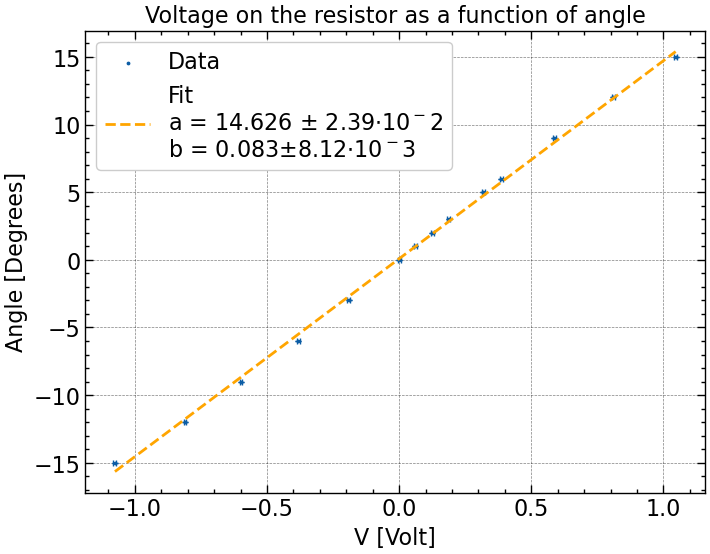

In [3]:
dir = 'Data\\Calibration'

v_R_data = pd.DataFrame(columns=['angle', 'mean voltage', 'voltage std'], dtype='float64')

with os.scandir(dir) as it:
        for file in it:
            point = pd.read_csv(file, sep='\t', skiprows=6)
            row = {'angle':int(file.name.split(".")[0]), 'mean voltage':point['Ch0[V]'].mean(), 
                   'voltage std':point['Ch0[V]'].std()}
            v_R_data = pd.concat([v_R_data, pd.Series(row, dtype='float64').to_frame().T], ignore_index=True)
v_R_data = v_R_data.sort_values('angle')

def fit_V_R(V, a, c):
      return a*V + c

fit_v = np.linspace(v_R_data['mean voltage'].min(), v_R_data['mean voltage'].max(), 100, endpoint=True)
popt, pcov = curve_fit(fit_V_R, v_R_data['mean voltage'], v_R_data['angle'])
fit_theta = fit_V_R(fit_v, *popt)


plt.figure()
plt.scatter(y=v_R_data['angle'], x=v_R_data['mean voltage'], s=3, label='Data')
plt.errorbar(y=v_R_data['angle'], x=v_R_data['mean voltage'], xerr=1/180,yerr=v_R_data['voltage std'],
             elinewidth=1, capsize=2, linestyle='None')
plt.plot(fit_v, fit_theta, color='orange', linestyle='dashed', 
         label=f'Fit\na = {popt[0]:.3f} $\pm$ {sci_notation(pcov[0][0], 2)}\nb = {popt[1]:.3f}$ \pm ${sci_notation(pcov[1][1], 2)}')
plt.legend()
plt.ylabel('Angle [Degrees]')
plt.xlabel('V [Volt]')
plt.title('Voltage on the resistor as a function of angle')

a, b = popt

In [4]:

def V_to_deg(v):
      return a*v + b

def deg_to_V(angle):
      return (1/a)*angle - (b/a)

### General functions

In [5]:
ANGLE = 'Ch0[V]'
VOLT = 'Ch1[V]'

In [6]:
lam= 632.8 * nm
K = np.pi * 2 / lam
n_fit = 4000

def fit_r_squared(fit_func, x, y, popt):
    residuals = y - fit_func(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def print_parameters(popt, pcov, name):
        print(f"{name}:")
        print(popt)
        print(pcov.diagonal())

def get_data(dir, files_array):
    data_array = []
    for file in files_array:
        data = pd.read_csv(dir+file, sep='\t', skiprows=6)
        data[ANGLE] = data[ANGLE].map(V_to_deg)
        data[VOLT] = -1 * data[VOLT]
        x = file.split()
        slit_width = x[0]
        data_array.append((data, slit_width))             
    return data_array
        
def fit_and_plot_diffraction_pattern(dir, files_array, bound, fit_func, fig_size, title, x_lim = None):
    data_array = get_data(dir, files_array)
    fig, ax = plt.subplots(nrows=len(data_array), ncols=1, layout='constrained', 
                           figsize = fig_size)
    fig.supxlabel(r"$\theta$ [degrees]")
    fig.supylabel('V [volt]')

    i = 0
    if len(data_array) > 1:
        fig.suptitle(title)
        for data, width in data_array:
            # data
            ax[i].scatter(data[ANGLE], data[VOLT],  s=2, label='Data')
            ax[i].set_title(f"slit width = {width} mm")
            # fit
            theta_fit = np.linspace(data[ANGLE].min(),data[ANGLE].max(), n_fit)
            popt, pcov = curve_fit(fit_func, data[ANGLE], data[VOLT], bounds=bound[i], maxfev=1000)
            v_fit = fit_func(theta_fit, *popt)
            print_parameters(popt, pcov, width)
            print(fit_r_squared(fit_func, data[ANGLE], data[VOLT], popt))
            ax[i].plot(theta_fit, v_fit, color='orange', linestyle='dashed', linewidth = 1.5, label='fit')
            if x_lim:
                ax[i].set_xlim(x_lim[0], x_lim[1])
            ax[i].legend()

            i += 1
    
    else: # because ax[i] didnt work for one axes ...
        data,width = data_array[0]
        fig.suptitle(f"{title} {width} mm")
        ax.scatter(data[ANGLE], data[VOLT],  s=2, label='Data')
        # fit
        theta_fit = np.linspace(data[ANGLE].min(),data[ANGLE].max(), n_fit)
        popt, pcov = curve_fit(fit_func, data[ANGLE], data[VOLT], bounds=bound[i], maxfev=2000)
        v_fit = fit_func(theta_fit, *popt)
        print_parameters(popt, pcov, width)
        print(fit_r_squared(fit_func, data[ANGLE], data[VOLT], popt))
        ax.plot(theta_fit, v_fit, color='orange', linestyle='dashed', linewidth = 1.5, label='fit')
        if x_lim:
            ax.set_xlim(x_lim[0], x_lim[1])
        ax.legend()
    return popt, pcov


### Single slit

In [68]:
def single_slit(theta, slit_width, I0, alpha):
    beta = (slit_width * K * np.sin(np.deg2rad(theta) - alpha)) / 2
    return I0 * ((np.sin(beta)) / beta)**2

def single_slit_width002(theta, I0, lamda, alpha):
    beta = ((0.02*mm * (np.pi / lamda)) * np.sin(np.deg2rad(theta) - alpha))
    return I0 * ((np.sin(beta)) / beta)**2

In [60]:
dir = 'Data\\Single slit\\'
files = ['0.02 mm first try.txt', 
          '0.02 mm 2nd try.txt',
          '0.02 mm 3rd try.txt',
          '0.02 mm 4th try.txt',
          '0.02 mm 5th try.txt',
          '0.02 mm 6th try.txt',
          '0.04 mm 1st try.txt',
          '0.08 mm 1st try.txt',
          '0.16 mm 1st try.txt']
ANGLE = 'Ch0[V]'
VOLT = 'Ch1[V]'
# [0-5] - 0.02mm
# [6,7,8] - 0.04,0.08,0.16

#### find slit geometry

0.02:
[4.40888760e+00 6.31882751e-07 3.93019098e-03]
[1.98807639e-02 4.47982260e-16 2.09653888e-07]
0.22351532700256993
0.02:
[8.71143321e+00 6.24906629e-07 8.26005151e-03]
[9.63984198e-02 5.38155846e-16 2.44385352e-07]
0.17072347049179026
0.02:
[9.34858061e+00 5.75714499e-07 8.84956455e-03]
[4.24643955e-02 1.74291025e-16 8.05886481e-08]
0.7554349532138835
0.02:
[1.00000000e+01 6.20056899e-07 3.87519120e-03]
[4.92919829e-02 1.97953953e-16 9.22707210e-08]
0.8244373787901328
0.02:
[8.50274386e+00 5.79829663e-07 5.12794541e-03]
[2.63443599e-02 1.29341925e-16 6.07380433e-08]
0.8307707065044979
0.02:
[8.16757465e+00 5.89770119e-07 4.76060749e-03]
[2.28295531e-02 1.49020515e-16 7.47312617e-08]
0.844586849369622


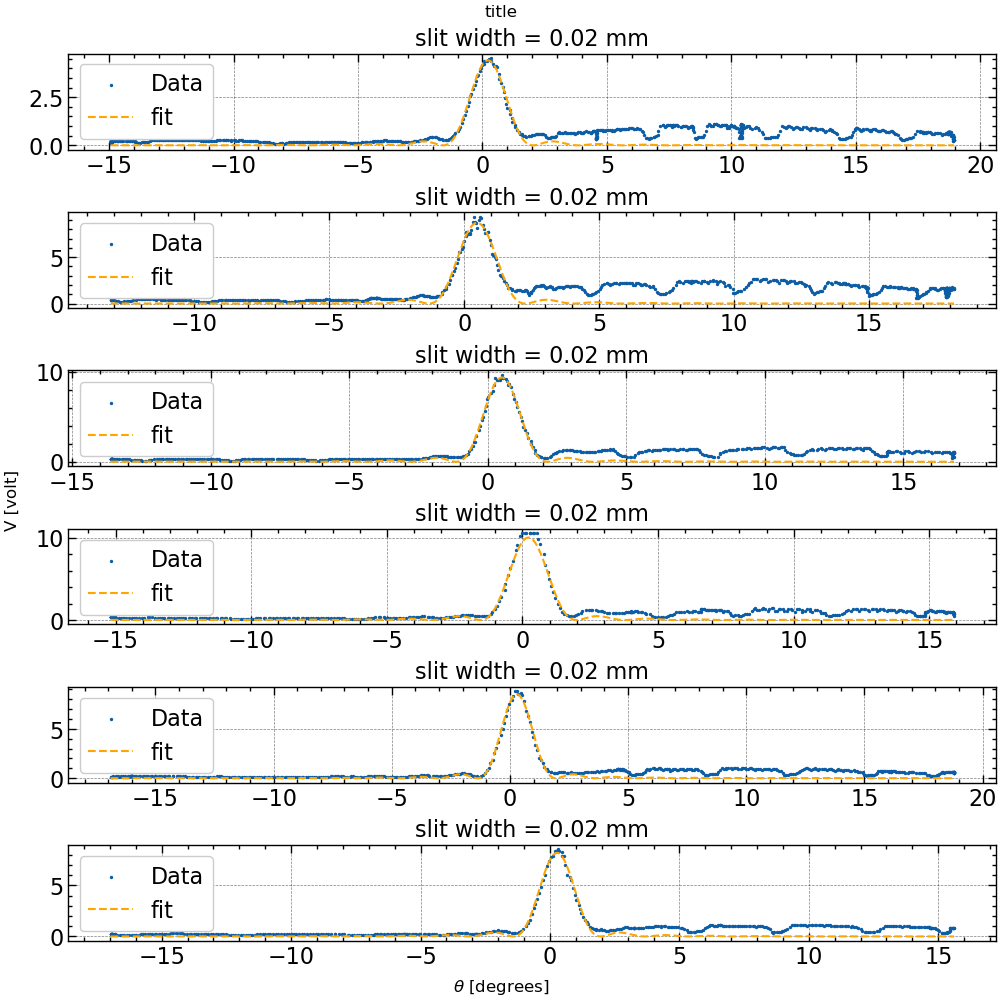

In [21]:
# 0.02 mm :
pcov, popt = fit_and_plot_diffraction_pattern(dir, files[0:6], 
                                 [[[0, 500*nm, 0],[10, 700*nm, np.deg2rad(1)]] for i in range(6)], 
                                 single_slit_width002,(10,10), 'title')

0.02:
[2.15025742e-05 8.17427184e+00 4.76143962e-03]
[1.97634854e-13 2.30763368e-02 7.44606035e-08]
0.8445891955738527
0.04:
[4.25242132e-05 9.65217989e+00 4.25779288e-03]
[2.00002886e-13 6.54653057e-03 4.38618989e-09]
0.9728000669891983
0.08:
[8.42469396e-05 1.61704236e+00 5.18266824e-03]
[9.76873489e-13 3.46571490e-04 1.48102807e-09]
0.9496268597842277
0.16:
[1.93464595e-04 5.08955566e+00 4.23304645e-03]
[3.07918225e-12 1.85679717e-03 1.37722058e-10]
0.9765201065898724


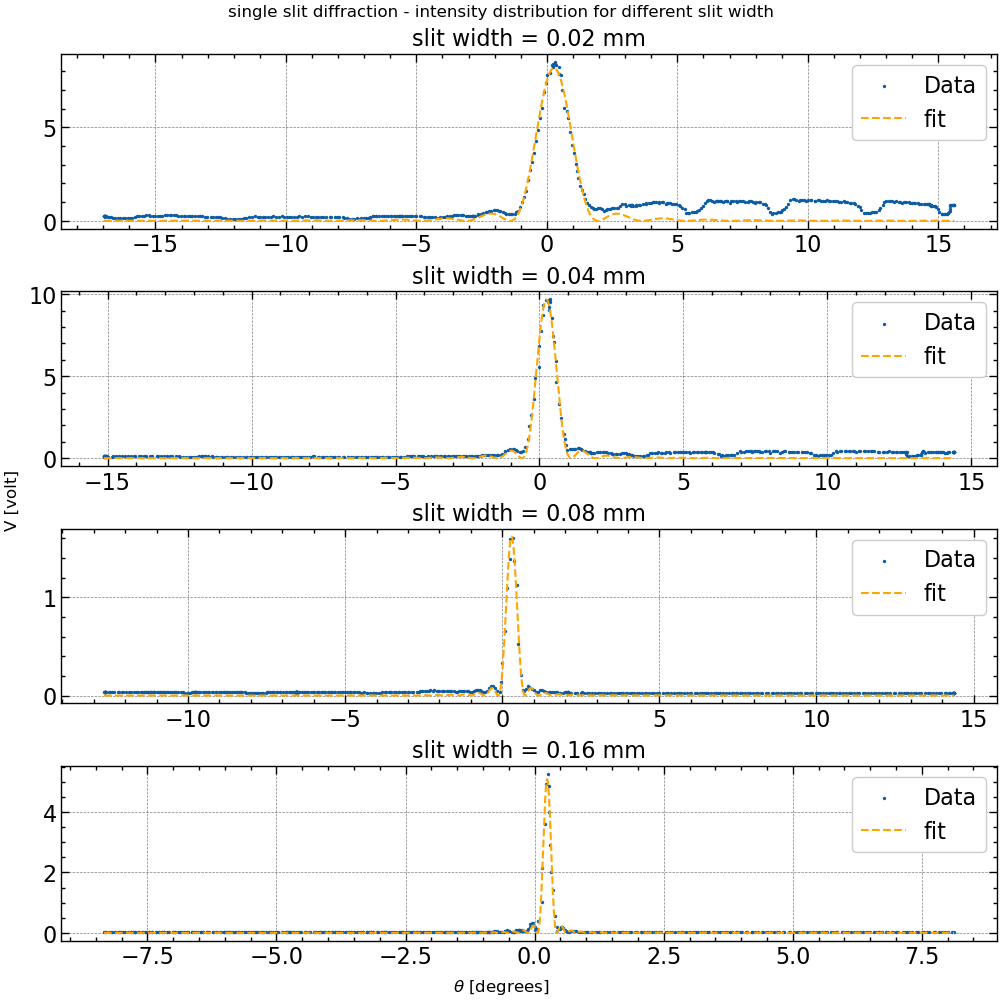

In [274]:
pcov, popt = fit_and_plot_diffraction_pattern(dir, files[5:9], 
                                 [[[0.02*mm, 0, 0],[0.2*mm, 10, np.deg2rad(1)]] for i in range(4)], 
                                 single_slit, (10,10), 
                                 'single slit diffraction - intensity distribution for different slit width')

#### find lamda

In [66]:
lamda_array_single = []

0.02:
[8.16757465e+00 5.89770119e-07 4.76060749e-03]
[2.28295531e-02 1.49020515e-16 7.47312617e-08]
0.844586849369622


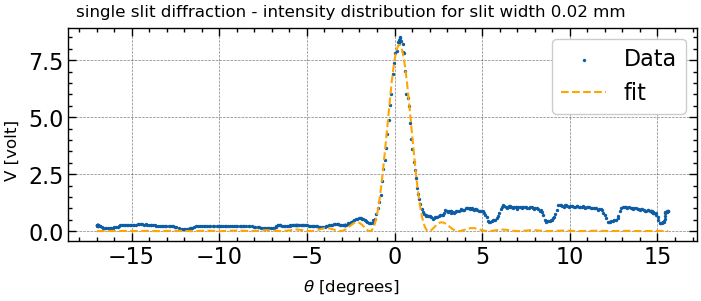

In [69]:
popt, pcov = fit_and_plot_diffraction_pattern(dir, [files[5]], 
                                 [[[0, 500*nm, 0],[10, 700*nm, np.deg2rad(1)]]], 
                                 single_slit_width002, (7,3), 
                                 'single slit diffraction - intensity distribution for slit width')

lamda_array_single.append(popt[1])

0.04:
[9.64229426e+00 5.96929654e-07 4.25719676e-03]
[6.46410677e-03 3.95345725e-17 4.41215966e-09]
0.9727962690034668


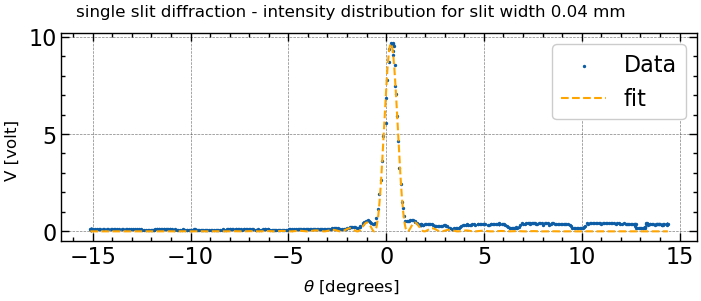

In [70]:
def single_slit_width004(theta, I0, lamda, alpha):
    beta = ((0.04*mm * (np.pi / lamda)) * np.sin(np.deg2rad(theta) - alpha))
    return I0 * ((np.sin(beta)) / beta)**2

popt, pcov = fit_and_plot_diffraction_pattern(dir, [files[6]], 
                                 [[[0, 500*nm, 0],[10, 700*nm, np.deg2rad(1)]]], 
                                 single_slit_width004, (7,3), 
                                 'single slit diffraction - intensity distribution for slit width')

lamda_array_single.append(popt[1])

0.08:
[1.61523480e+00 3.01144013e-07 5.18279258e-03]
[3.39827133e-04 1.27815997e-17 1.48786228e-09]
0.9496240871944834


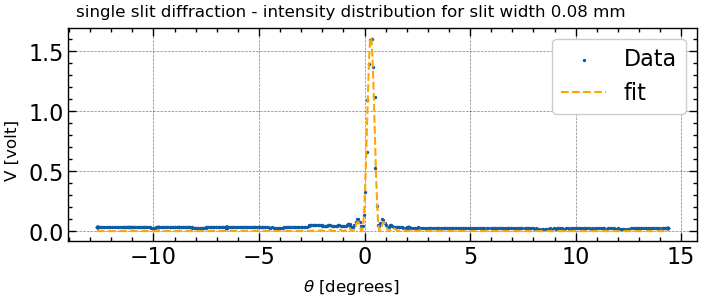

In [71]:
def single_slit_width008(theta, I0, lamda, alpha):
    beta = ((0.08*mm * (np.pi / lamda)) * np.sin(np.deg2rad(theta) - alpha))
    return I0 * ((np.sin(beta)) / beta)**2

popt, pcov = fit_and_plot_diffraction_pattern(dir, [files[7]], 
                                 [[[0, 300*nm, 0],[10, 700*nm, np.deg2rad(1)]]], 
                                 single_slit_width004, (7,3), 
                                 'single slit diffraction - intensity distribution for slit width')
lamda_array_single.append(popt[1])

0.16:
[5.01998028e+00 1.34386185e-07 4.23350961e-03]
[1.75148115e-03 1.69980150e-18 1.49226208e-10]
0.9762669887810098


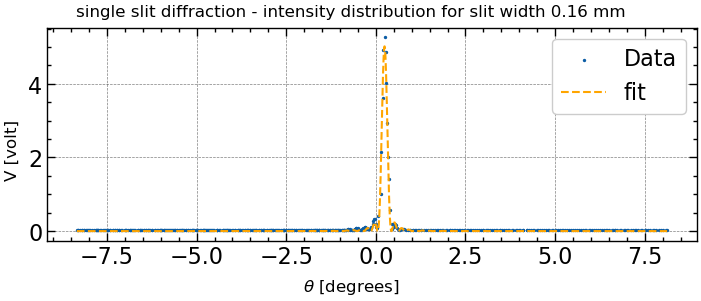

In [72]:
def single_slit_width016(theta, I0, lamda, alpha):
    beta = ((0.16*mm * (np.pi / lamda)) * np.sin(np.deg2rad(theta) - alpha))
    return I0 * ((np.sin(beta)) / beta)**2

popt, pcov = fit_and_plot_diffraction_pattern(dir, [files[8]], 
                                 [[[0, 100*nm, 0],[10, 700*nm, np.deg2rad(1)]]], 
                                 single_slit_width004, (7,3), 
                                 'single slit diffraction - intensity distribution for slit width')
lamda_array_single.append(popt[1])

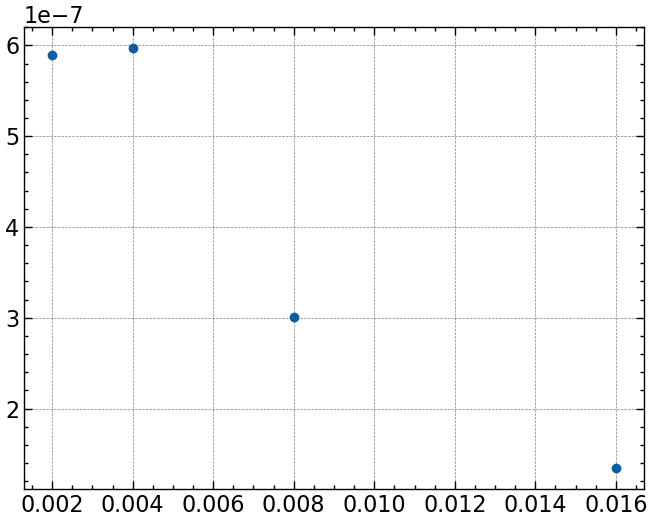

In [75]:
plt.scatter([0.002, 0.004, 0.008, 0.016], lamda_array_single)

### Double slits

In [80]:
def double_slits_space_025(theta, slit_width, I0, gamma):
    alpha = (0.25*mm * K * np.sin(np.deg2rad(theta) - gamma)) / 2
    beta = (slit_width * K * np.sin(np.deg2rad(theta) - gamma)) / 2
    return I0 * (np.sin(beta)/beta)**2 * np.cos(alpha)**2

def double_slits_space_05(theta, slit_width, I0, gamma):
    alpha = (0.5*mm * K * np.sin(np.deg2rad(theta) - gamma)) / 2
    beta = (slit_width * K * np.sin(np.deg2rad(theta) - gamma)) / 2
    return I0 * ((np.sin(beta)/beta)**2 * np.cos(alpha)**2)

In [81]:
dir = 'Data\\two slits\\'
files = ['0.04 mm with space 0.25 mm.txt', 
         '0.08 mm with space 0.25 mm.txt', 
         '0.04 mm with space 0.5 mm.txt', 
         '0.08 mm with space 0.5 mm.txt']
ANGLE = 'Ch1[V]'
VOLT = 'Ch0[V]'

#### find geometry

0.04:
[4.00511852e-05 1.00000000e+01 3.66653290e-03]
[9.07262125e-14 5.90120686e-03 2.01928783e-11]
0.8895393030598321
0.08:
[8.46378144e-05 8.52308731e+00 4.77457955e-03]
[1.88178341e-13 1.39812717e-03 7.15985860e-12]
0.9414866612046381


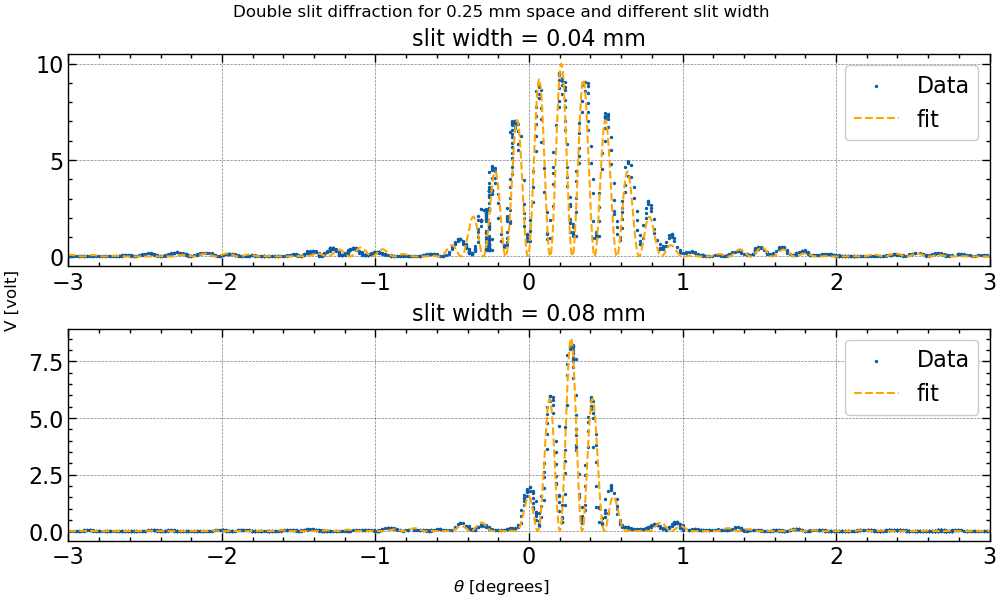

In [340]:
fit_and_plot_diffraction_pattern(dir, files[0:2], 
                                [[[0.01*mm, 0, np.deg2rad(0.1)], [0.1*mm, 10, np.deg2rad(0.45)]], 
                                 [[0.04*mm, 0, np.deg2rad(0.1)], [0.1*mm, 10, np.deg2rad(0.45)]]], 
                                double_slits_space_025,
                                (10,6),
                                'Double slit diffraction for 0.25 mm space and different slit width',     
                                x_lim=[-3, 3])

0.04:
[4.29706828e-05 8.94892322e+00 4.42865910e-03]
[4.89937359e-13 1.45028679e-02 1.47731214e-11]
0.5601710425106126
0.08:
[ 7.50000000e-05  9.75190134e+00 -1.81280117e-03]
[7.76178901e-13 1.14710882e-02 1.11894869e-11]
0.7110566536709988


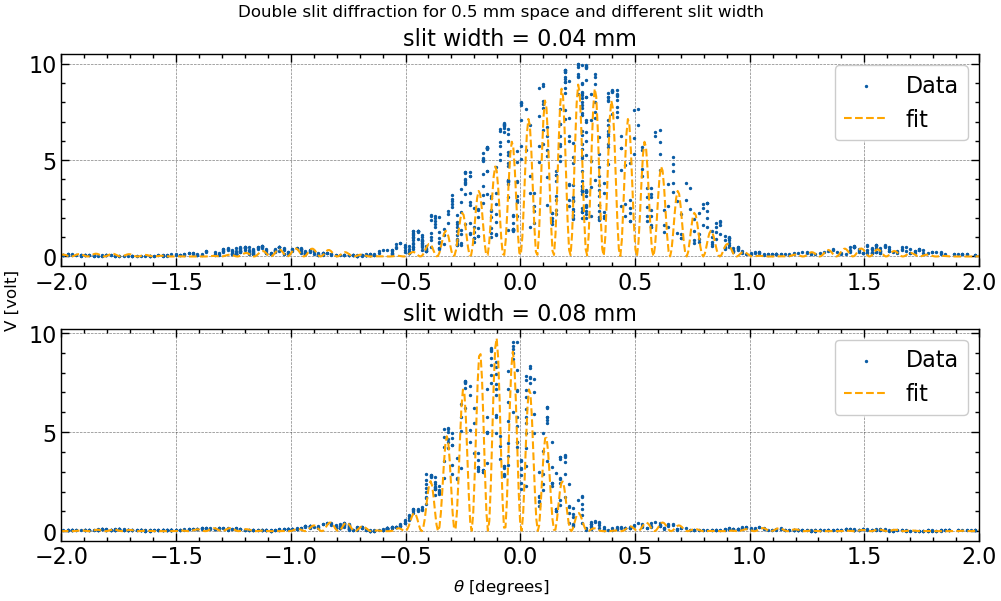

In [347]:
fit_and_plot_diffraction_pattern(dir, files[2:], 
                                [[[0.01*mm, 0, np.deg2rad(0.1)], [0.1*mm, 10, np.deg2rad(0.45)]], 
                                 [[0.075*mm, 0, np.deg2rad(-0.25)], [0.85*mm, 10, np.deg2rad(0)]]], 
                                double_slits_space_05,
                                (10,6), 
                                'Double slit diffraction for 0.5 mm space and different slit width',     
                                x_lim=(-2,2))

#### find lamda

In [99]:
lamda_array_double = [[], []]

0.04:
[8.58422023e+00 5.40768117e-07 4.21788989e-03]
[2.48306899e-02 2.83808524e-18 1.19935585e-10]
0.4564441388036863


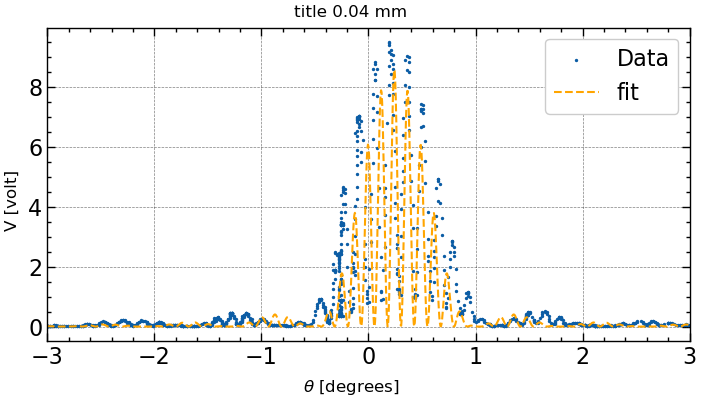

In [100]:
def double_slit_space025_width004(theta, I0, lamda, gamma):
    alpha = (0.25*mm * (2*np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma)) / 2
    beta = (0.04*mm * (2*np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma)) / 2
    return I0 * (np.sin(beta)/beta)**2 * np.cos(alpha)**2

popt, pcov = fit_and_plot_diffraction_pattern(dir, [files[0]], 
                                [[[7, 500*nm, np.deg2rad(0.1)], [10, 700*nm, np.deg2rad(0.45)]]], 
                                double_slit_space025_width004,
                                (7,4), 
                                'title',
                                x_lim=(-3, 3))
lamda_array_double[0].append(popt[1])

0.08:
[8.62160911e+00 6.01410158e-07 4.77000602e-03]
[7.85618595e-04 4.51633261e-19 4.42690334e-12]
0.9581934291060322


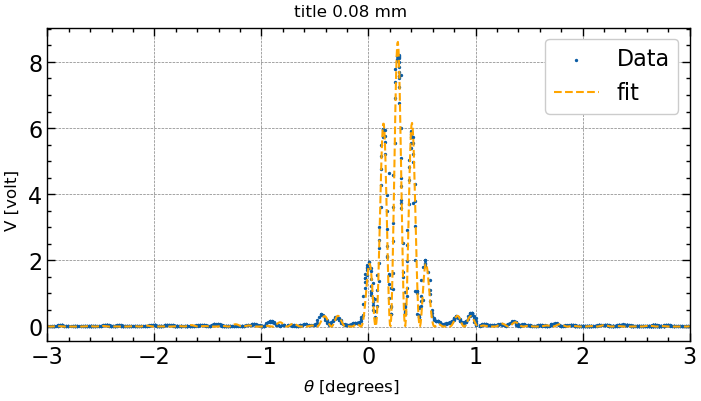

In [101]:
def double_slit_space025_width008(theta, I0, lamda, gamma):
    alpha = (0.25*mm * (2*np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma)) / 2
    beta = (0.08*mm * (2*np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma)) / 2
    return I0 * (np.sin(beta)/beta)**2 * np.cos(alpha)**2

popt, pcov = fit_and_plot_diffraction_pattern(dir, [files[1]], 
                                [[[7, 500*nm, np.deg2rad(0.1)], [10, 700*nm, np.deg2rad(0.45)]]], 
                                double_slit_space025_width008,
                                (7,4), 
                                'title',
                                x_lim=(-3, 3))
lamda_array_double[0].append(popt[1])

0.04:
[8.88871881e+00 6.90772949e-07 4.39348731e-03]
[8.27305458e-03 4.60771170e-19 1.32978129e-11]
0.6431788758181778


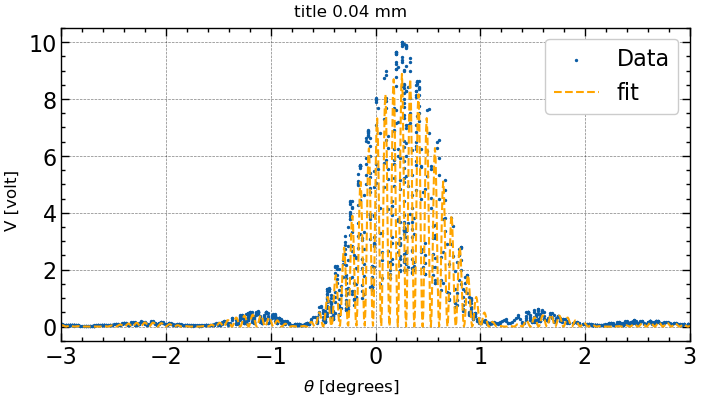

In [102]:
def double_slit_space05_width004(theta, I0, lamda, gamma):
    alpha = (0.5*mm * (2*np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma)) / 2
    beta = (0.04*mm * (2*np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma)) / 2
    return I0 * (np.sin(beta)/beta)**2 * np.cos(alpha)**2

popt, pcov = fit_and_plot_diffraction_pattern(dir, [files[2]], 
                                [[[0, 500*nm, np.deg2rad(0.01)], [10, 700*nm, np.deg2rad(0.45)]]], 
                                double_slit_space05_width004,
                                (7,4), 
                                'title',
                                x_lim=(-3, 3))
lamda_array_double[1].append(popt[1])

0.08:
[ 9.93197543e+00  6.40737393e-07 -1.82362586e-03]
[9.31285264e-03 1.19016397e-18 1.24273831e-11]
0.6978636910662586


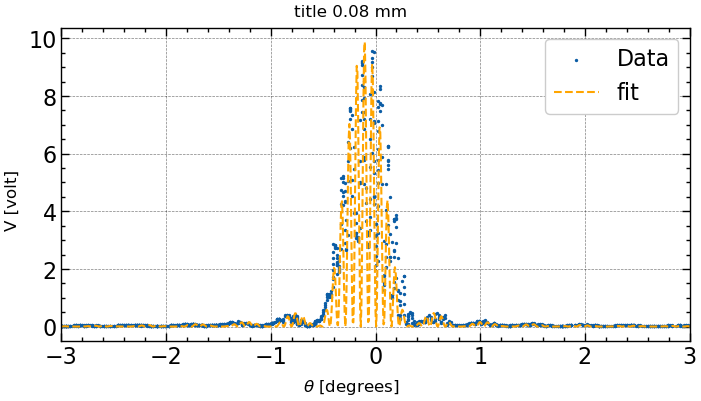

In [103]:
def double_slit_space05_width008(theta, I0, lamda, gamma):
    alpha = (0.5*mm * (2*np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma)) / 2
    beta = (0.08*mm * (2*np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma)) / 2
    return I0 * (np.sin(beta)/beta)**2 * np.cos(alpha)**2

popt, pcov = fit_and_plot_diffraction_pattern(dir, [files[3]], 
                                [[[0, 500*nm, np.deg2rad(-0.15)], [10, 700*nm, np.deg2rad(-0.01)]]], 
                                double_slit_space05_width008,
                                (7,4), 
                                'title',
                                x_lim=(-3, 3))
lamda_array_double[1].append(popt[1])

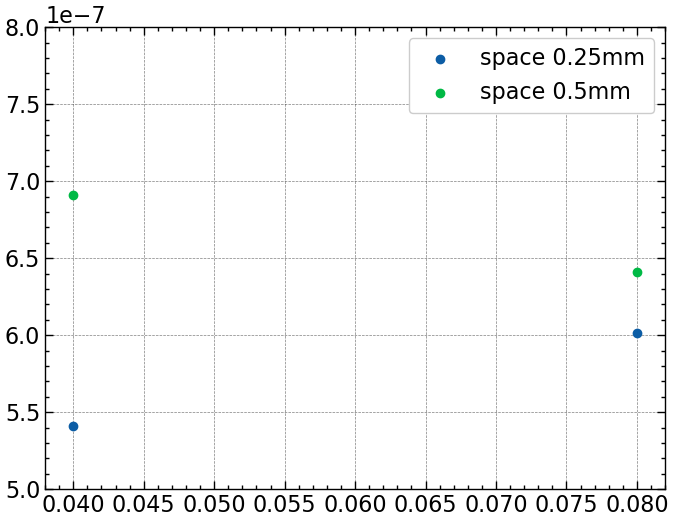

In [105]:
plt.figure()
plt.scatter([0.04, 0.08], lamda_array_double[0], label='space 0.25mm')
plt.scatter([0.04, 0.08], lamda_array_double[1], label='space 0.5mm')
plt.ylim(500*nm, 800*nm)
plt.legend()


### N slits

In [12]:
def n_slits(theta, slit_width, I0, gamma, N):
    alpha = (0.125*mm * K * np.sin(np.deg2rad(theta) - gamma)) / 2
    beta = (slit_width * K * np.sin(np.deg2rad(theta) - gamma)) / 2
    return I0 * (np.sin(beta)/beta)**2 * (np.sin(N*alpha)/np.sin(alpha))**2

In [13]:
dir = 'Data\\n slits\\'
files = ['n slits 8 lines per mm.txt', 
         '3 slits 0.04 mm with space 0.125 mm.txt']

n:
[ 5.99930367e-05  4.30697163e-02 -1.10184056e-03  5.00194137e+00]
[1.25563136e-11 4.53523073e-05 3.41183557e-12 5.38297457e-07]
-0.08110018527713891


(array([ 5.99930367e-05,  4.30697163e-02, -1.10184056e-03,  5.00194137e+00]),
 array([[ 1.25563136e-11,  1.77594094e-08,  3.11803036e-12,
         -1.20038901e-10],
        [ 1.77594094e-08,  4.53523073e-05,  4.63088569e-09,
          7.90576846e-07],
        [ 3.11803036e-12,  4.63088569e-09,  3.41183557e-12,
         -6.63235704e-10],
        [-1.20038901e-10,  7.90576846e-07, -6.63235704e-10,
          5.38297457e-07]]))

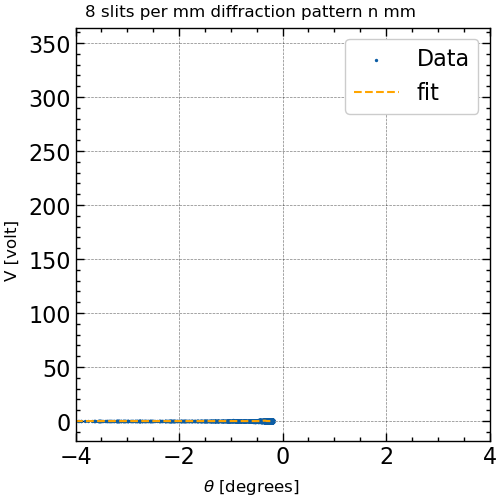

In [14]:
fit_and_plot_diffraction_pattern(dir, [files[0]], 
                                [[[0.03*mm, 0, np.deg2rad(-0.1), 0], 
                                  [0.06*mm, 1, np.deg2rad(-0.01), 10]]],
                                n_slits,
                                (5,5),  
                                '8 slits per mm diffraction pattern',   
                                x_lim=(-4,4))